
<td> <img src="https://kuvat.kaakonviestinta.fi/img/855/12a7a0ec312db2b662c9dda267f56f88" width="200" height="200" /> </td>

# Kouvolan ostolaskudata ja Kouvolan kaupungin ATK -hankinnat

Ostolaskuaineisto sijaitsee osoitteessa https://www.kouvola.fi/kouvolankaupunki/kouvola-tietoa/avoin-data/
Jokainen tiedosto ladataan pandasiin omana dataframena komennolla `pd.read_excel` suoraan Kouvolan verkkosivuilta. Pandasin excel-tuen saa asentamalla `xlrd` -moduulin. Dataa siivotaan ja yhdistetään ennen varsinaista analyysiä. Tällä työkalulla voi siivota ja yhdistää Kouvolan ostolaskuaineiston kätevästi nappia painamalla.

### Datan tuonti

In [1]:
import pandas as pd

#Lukee ostolaskudatan Kouvolan kaupungin nettisivuilta seitsemäksi eri dataframeksi

df1 = pd.read_excel('https://www.kouvola.fi/wp-content/uploads/2018/12/Ostolaskut_2013.xlsx')
df2 = pd.read_excel('https://www.kouvola.fi/wp-content/uploads/2018/12/Ostolaskut_2014.xlsx')
df3 = pd.read_excel('https://www.kouvola.fi/wp-content/uploads/2018/12/Ostolaskut_2015.xlsx')
df4 = pd.read_excel('https://www.kouvola.fi/wp-content/uploads/2018/12/Ostolaskut_2016.xlsx')
df5 = pd.read_excel('https://www.kouvola.fi/wp-content/uploads/2018/12/Ostolaskut_2017.xlsx')
df6 = pd.read_excel('https://www.kouvola.fi/wp-content/uploads/2019/04/Ostolaskut_2018.xlsx')
df7 = pd.read_excel('https://www.kouvola.fi/wp-content/uploads/2020/05/Ostolaskut_2019.xlsx')


### Datan siivoaminen ja tiedostojen yhdistäminen

Nämä dataframet liitetään yhteen pythonin concatenation-toiminnolla (tai sen pandas-funktiolla `pd.concat`), joka käytännössä liittää kaikki tiedostot yhteen ja samaan pötköön. Tämän edellytys on, että kaikissa tiedostoissa on identtiset sarakkeet. Erillisiä dataframeja tarkastelemalla saatiin selville, että näin ei ollut asia. Datan siivoamiseksi ennen liittämistä tehtiin seraavat toimenpiteet:

- 2018 ja 2019 tiedostoista muutettiin sarakkeiden nimet Toimittaja-nro -> Toimittajanro ja Laskun nettosumma -> Nettosumma
- Muutettu sarake "Y-tunnus" selkeyden vuoksi muotoon "Toimittajan_Y-tunnus"
- Vuoden 2015 tiedostosta muutettu erikseen sarakkeen nimi Y-tunnus -> "Toimittajan_Y-tunnus" koska erilainen väliviiva
- Poistettu laskujen yhteissummaa osoittavat summarivit tiedostoista
- Poistettu vuoden 2013 dataframesta neljä tyhjää Unnamed-saraketta

In [2]:
#lista dataframeista ja sarakkeiden nimien muuttaminen siten, että ne ovat kaikissa identtiset (ja kätevät)

dfs = [df1, df2, df3, df4, df5, df6, df7]

renames_dfs = []
for df in dfs:
    df.rename(columns={'Y-tunnus':'Toimittajan_Y-tunnus','Laskun nettosumma': 'Nettosumma',
                      'Toimittaja-nro': 'Toimittajanro', 'Tilin nimi': 'Tilin_nimi',
                      'Laskun loppusumma': 'Laskun_loppusumma', 'Toimittajan nimi' : 'Toimittajan_nimi'}, 
                       inplace=True)

df3.rename(columns={'Y-tunnus ': 'Toimittajan_Y-tunnus'}, inplace=True)

#neljän tyhjän sarakkeen poisto vuoden 2013 tiedostosta

del df1['Unnamed: 16']
del df1['Unnamed: 17']
del df1['Unnamed: 18']
del df1['Unnamed: 19']

#kaikkien datafreimien liittäminen toisiinsa yhdeksi isoksi dataframeksi

dataframe = pd.concat(dfs) 

#summarivien poisto poistamalla NaN-arvot Kirjauspvm -sarakkeesta

dataframe = dataframe.dropna(subset=['Kirjauspvm'])

#päivämäärädataa sisältävien sarakkeiden parsiminen pandasin to_datetime -komennolla

dataframe['Laskun pvm']= pd.to_datetime(dataframe['Laskun pvm'])
dataframe['Kirjauspvm']= pd.to_datetime(dataframe['Kirjauspvm'])

#asetusten säätöä sille miten dataa näytetään tässä notebookissa 

pd.options.display.max_rows = 1000 #max rivit ennenkuin lyhentää
pd.set_option('display.float_format', lambda x: '%.5f' % x) #tieteellinen notaatio pois floateista
pd.options.display.float_format = "{:,.2f}".format #floatit kahden desimaalin mittaisiksi

#uusi sarake 'n' joka saa jokaisella rivillä arvon 1ja sarakkeet netto- ja loppusummien erotukselle ja veroprosentille

dataframe['n'] = 1
dataframe['Vero€'] = dataframe['Laskun_loppusumma'] - dataframe['Nettosumma']
dataframe['Vero%'] = (dataframe['Vero€'] / dataframe['Laskun_loppusumma']) *100

#rivien ja sarakkeiden lukumäärä

dataframe.shape


(710026, 19)

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710026 entries, 0 to 62677
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Kuntanro              710019 non-null  float64       
 1   Kunnan nimi           710019 non-null  object        
 2   Ostajan Y-tunnus      710019 non-null  object        
 3   Toimialatunnus        709969 non-null  object        
 4   Toimiala              709969 non-null  object        
 5   Laskun pvm            710026 non-null  datetime64[ns]
 6   Tositenro             709975 non-null  float64       
 7   Kirjauspvm            710026 non-null  datetime64[ns]
 8   Tiliryhmä 1           710015 non-null  object        
 9   Tilin nro             710015 non-null  float64       
 10  Tilin_nimi            709241 non-null  object        
 11  Toimittajan_nimi      710026 non-null  object        
 12  Toimittajan_Y-tunnus  704258 non-null  object        
 13  

In [ ]:
dataframe['Tilin_nimi'].value_counts()

# Atk- ja ICT-hankintojen tarkastelu

Tilin_nimi -sarakkeesta suodatetaan Atk-palvelut ja ICT-palvelut tileiltä maksetut laskut ja tallennetaan ne uusiin muuttujiin ja lisäksi muuttujat vuosille 2014 ja 2015. Eli yhteensä luodaan 4 uutta dataframea ja indeksoidaan ne päivämäärän mukaan

In [6]:
import numpy as np
import matplotlib.pyplot as plt

ICT = dataframe[dataframe.Tilin_nimi == 'ICT-palvelut']
ATK = dataframe[dataframe.Tilin_nimi == 'Atk-palvelut']
ATKICT = dataframe.loc[dataframe['Tilin_nimi'].isin(['ICT-palvelut','Atk-palvelut'])]

ICT = ICT.set_index('Kirjauspvm')
ATK = ATK.set_index('Kirjauspvm')
ATKICT = ATKICT.set_index('Kirjauspvm')

In [7]:
#muuttujat vuosille 2014 ja 2015

ATK2014 = ATK['2014-01-01':'2014-12-31']
ICT2015 = ICT['2015-01-01':'2015-12-31']

In [10]:
ATK2014['Laskun_loppusumma'].describe()

count       797.00
mean     13,327.73
std      59,979.28
min      -4,714.17
25%         434.00
50%       1,116.00
75%       3,948.30
max     977,847.11
Name: Laskun_loppusumma, dtype: float64

In [9]:
ICT2015['Laskun_loppusumma'].describe()

count     2,331.00
mean      5,342.12
std      35,643.20
min      -1,324.32
25%         110.38
50%         440.20
75%       1,364.00
max     789,318.09
Name: Laskun_loppusumma, dtype: float64

### Aikasarjoja ATK- ja ICT-laskujen summista ja kappalemääristä

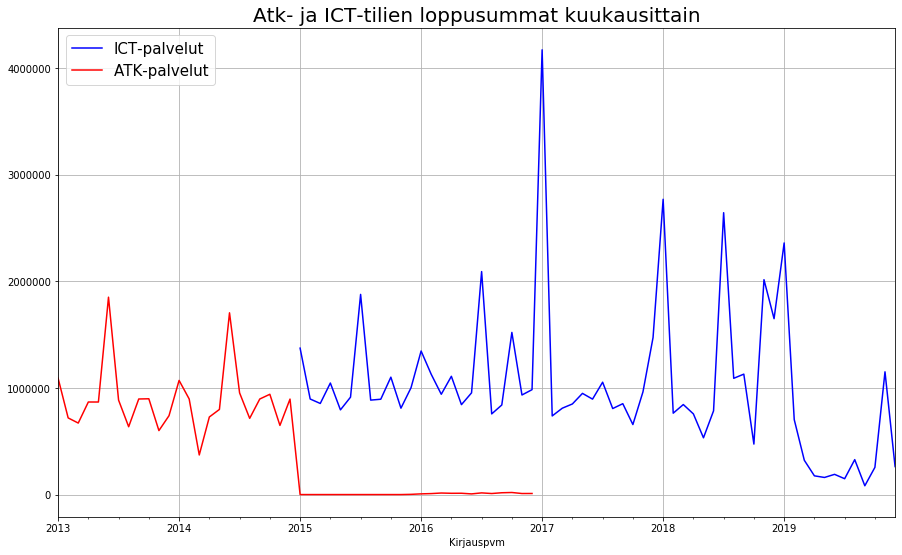

In [11]:
#aikasarja Atk- ja ICT-tilien loppusummat kuukausittain

plt.figure(figsize=(15,9))
plt.title('Atk- ja ICT-tilien loppusummat kuukausittain', fontsize=20)

ax1 = ICT.groupby(pd.Grouper(freq='1M')).Laskun_loppusumma.sum().plot(color='blue', grid=True, label='ICT-palvelut')
ax2 = ATK.groupby(pd.Grouper(freq='1M')).Laskun_loppusumma.sum().plot(color='red', grid=True, label='ATK-palvelut')

plt.legend(loc=2, prop={'size': 15})
plt.show()

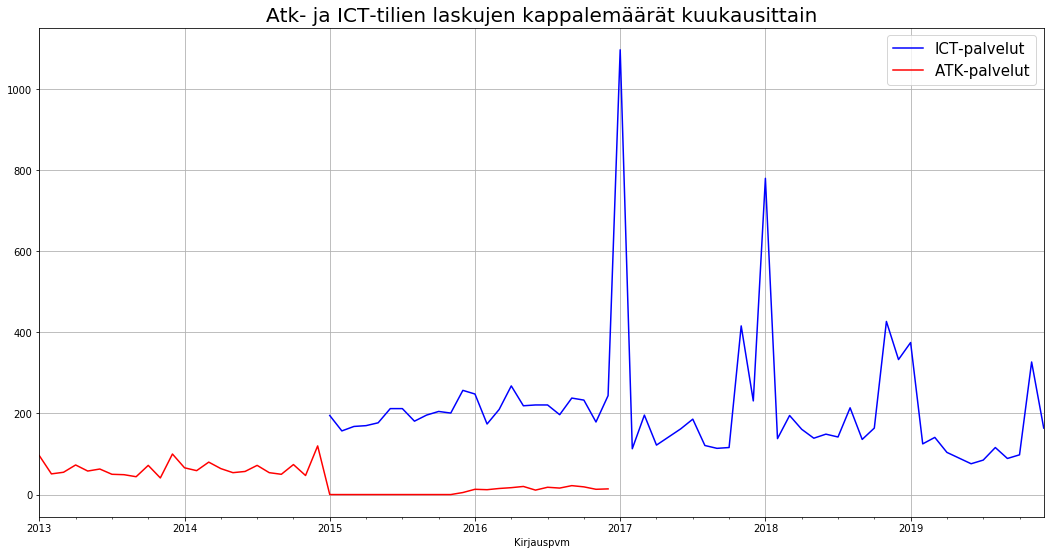

In [12]:
#aikasarja Atk- ja ICT-tilien laskujen kappalemäärät kuukausittain

plt.figure(figsize=(18,9))
plt.title('Atk- ja ICT-tilien laskujen kappalemäärät kuukausittain', fontsize=20)

ax1 = ICT.groupby(pd.Grouper(freq='1M')).n.sum().plot(color='blue', grid=True, label='ICT-palvelut')
ax2 = ATK.groupby(pd.Grouper(freq='1M')).n.sum().plot(color='red', grid=True, label='ATK-palvelut')

plt.legend(loc=1, prop={'size': 15})
plt.show()


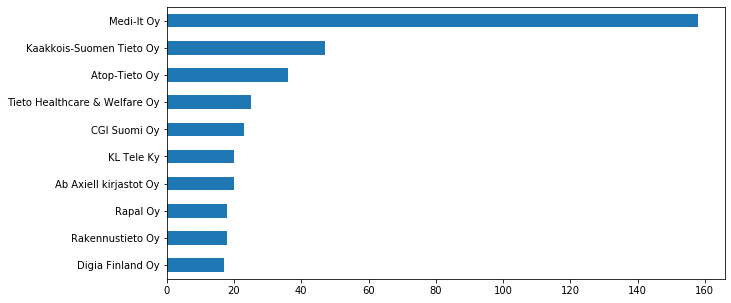

In [13]:
#2014 ATK-laskujen top 10 toimittajat

ax = ATK2014.Toimittajan_nimi.value_counts().sort_values(ascending= False)[:10].plot(kind = 'barh', figsize=(10,5))
ax.invert_yaxis()


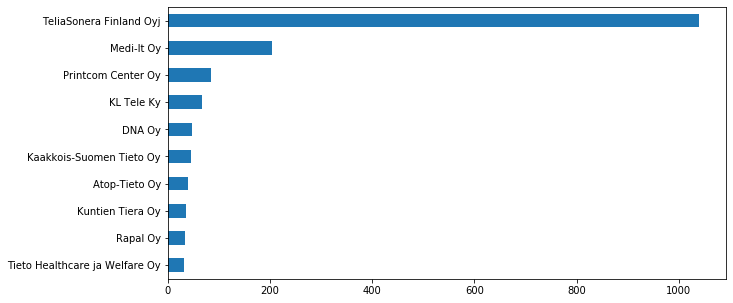

In [14]:
#2015 ICT-laskujen top 10 toimittajat

ax = ICT2015.Toimittajan_nimi.value_counts().sort_values(ascending= False)[:10].plot(kind = 'barh', figsize=(10,5))
ax.invert_yaxis()

In [19]:
#muuttuja TeliaSoneran vuoden 2014 laskuille, jotta nähdään miltä tileiltä ne on maksettu

TeliaSonera = dataframe[dataframe.Toimittajan_nimi == 'TeliaSonera Finland Oyj']
TeliaSonera = TeliaSonera.set_index('Kirjauspvm')
TeliaSonera2014 = TeliaSonera['2014-01-01':'2014-12-31']

#muuttuja TeliaFinlandin laskuille

TeliaFinland = dataframe.loc[dataframe['Toimittajan_nimi'].isin(['Telia Finland Oyj','Telia Finland Oy'])]
TeliaFinland = TeliaFinland.set_index('Kirjauspvm')

TeliaSonera2016 = TeliaSonera['2016-01-01' : '2016-12-31']
TeliaFinland2017 = TeliaFinland['2017-01-01' : '2017-12-31']

In [22]:
TeliaSonera2016['Laskun_loppusumma'].sum()

787338.18

In [23]:
TeliaFinland2017['Laskun_loppusumma'].sum()

655517.14

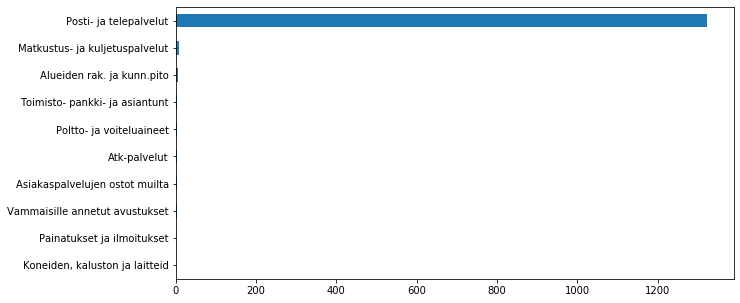

In [21]:
#TeliaSoneran 2014 laskujen tilit top10

ax = TeliaSonera2014.Tilin_nimi.value_counts().sort_values(ascending= False)[:10].plot(kind = 'barh', figsize=(10,5))
ax.invert_yaxis()


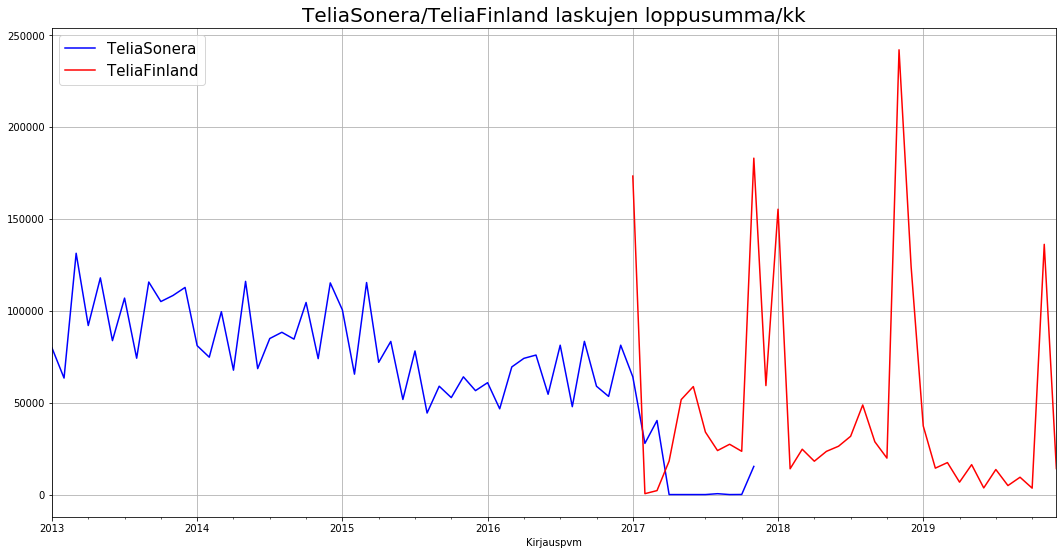

In [25]:
plt.figure(figsize=(18,9))
plt.title('TeliaSonera/TeliaFinland laskujen loppusumma/kk', fontsize=20)

ax1 = TeliaSonera.groupby(pd.Grouper(freq='1M')).Laskun_loppusumma.sum().plot(color='blue', grid=True,label = 'TeliaSonera')
ax2 = TeliaFinland.groupby(pd.Grouper(freq='1M')).Laskun_loppusumma.sum().plot(color='red', grid=True,label = 'TeliaFinland')
#ax2 = ATK.groupby(pd.Grouper(freq='1M')).n.sum().plot(color='red', grid=True, label='ATK-palvelut')

plt.legend(loc=2, prop={'size': 15})
plt.show()

### Det finns mer här

In [34]:
dataframe = dataframe.set_index('Kirjauspvm')
Vuosi2015 = dataframe['2015-01-01':'2015-12-31']
Vuosi2015['Tilin_nimi'].value_counts(normalize=True) * 100

Elintarvikkeet                   8.19
Asiakaspalvelujen ostot muilta   8.13
Sähkö ja kaasu                   6.55
Muu materiaali                   6.33
Hoitotarvikkeet                  4.45
Rakennusten ja huoneistojen vu   4.09
Matkustus ja kulj. palv. muut    3.89
Toimisto- ja asiantuntijapalve   3.35
Koneiden, kaluston ja laitteid   3.14
Rakennusten  rakentamis- ja ku   3.04
Rakennusmateriaali               3.04
Muu kalusto alle 1000 euroa      3.03
Jätehuoltomaksut                 3.01
Majoitus- ja ravitsemuspalvelu   2.52
Kirjallisuus                     2.37
ICT-palvelut                     2.22
Opetus- ja kulttuuripalvelut     2.11
Toimistotarvikkeet               2.08
Koulutarvikkeet                  1.61
Keskeneräiset hankinnat          1.60
Lämmitys                         1.60
Puhtaanapito- ja pesulapalvelu   1.58
Muut palvelut                    1.43
Vesi                             1.20
Alueiden rak. ja kunn.pito       1.19
Laboratoriopalvelut              1.15
Muut avustuk

In [35]:
Vuosi2014 = dataframe['2014-01-01':'2014-12-31']
Vuosi2014['Tilin_nimi'].value_counts(normalize=True) * 100

Elintarvikkeet                   9.02
Asiakaspalvelujen ostot muilta   6.81
Sähkö                            6.26
Muu materiaali                   6.01
Toimisto- pankki- ja asiantunt   4.31
Rakennusten ja huoneistojen vu   4.25
Hoitotarvikkeet                  4.06
Matkustus ja kulj. palv. muut    3.59
Koneiden, kaluston ja laitteid   3.32
Rakennusmateriaali               3.17
Muu kalusto alle 1000 euroa      3.17
Rakennusten  rakentamis- ja ku   2.75
Jätehuoltomaksut                 2.75
Majoitus- ja ravitsemuspalvelu   2.68
Kirjallisuus                     2.47
Toimistotarvikkeet               2.12
Keskeneräiset hankinnat          2.08
Opetus- ja kulttuuripalvelut     1.98
Koulutarvikkeet                  1.93
Lämmitys                         1.82
Muut palvelut                    1.68
Puhtaanapito- ja pesulapalvelu   1.64
Posti- ja telepalvelut           1.62
Puhdistusaineet ja tarvikkeet    1.38
Alueiden rak. ja kunn.pito       1.37
Terveyskeskusvarasto             1.21
Lääkkeet    

In [ ]:
ICT2015['Toimittajan_nimi'].value_counts()

In [ ]:
ATKICT['Tilin_nimi'].value_counts()

In [29]:
ATKICT['Toimittajan_nimi'].nunique()

564

In [36]:
ATK2014['Toimittajan_nimi'].nunique()

136

In [ ]:
ICT2015['Laskun_loppusumma'].describe()

In [ ]:
ATK2014['Laskun_loppusumma'].describe()

In [ ]:
ATK2014['Laskun_loppusumma'].sum()

In [ ]:
ICT2015['Laskun_loppusumma'].sum()

In [ ]:
#ICTc[ICTc < 0] = 0

In [ ]:
ICT2015['Laskun_loppusumma'].plot(kind='box', vert=False, figsize=(20,10))

In [ ]:
ATK2014['Laskun_loppusumma'].plot(kind='box', vert=False, figsize=(20,10))

In [ ]:
ICT2015['Laskun_loppusumma'].plot(kind='hist', figsize=(20,10))

In [ ]:

ICT2 = ICT[ICT['Laskun_loppusumma'] < 50000]
ICT3 = ICT[(ICT['Laskun_loppusumma'] > 0) & (ICT['Laskun_loppusumma'] <= 5000)]


In [ ]:
ICT3['Laskun_loppusumma'].sum()

In [ ]:
ICT['Laskun_loppusumma'].sum()

In [ ]:
ICT2['Laskun_loppusumma'].plot(kind='box', vert=False, figsize=(20,10))

In [ ]:
ICT3['Laskun_loppusumma'].plot(kind='box', vert=False, figsize=(20,10))

In [ ]:

dataframe['n'] = 1
ICT[["Kirjauspvm" , "n"]].groupby(ICT["Kirjauspvm"].dt.date).sum().plot()

In [ ]:
ICT[["Kirjauspvm" , "Laskun_loppusumma"]].groupby(ICT["Kirjauspvm"].dt.date).sum().plot()

In [ ]:
dataframe.to_csv('KVLostolaskut2013-2019.csv') #csv tiedoston kirjoittaminen Tableauta ja omaa R harjoittelua varten

In [ ]:
prh_data = pd.read_csv('/Users/kaisamaijatoots/Downloads/full_prh_data(2).csv', sep=';', 
                       usecols=['business_id', 'postal_post_code', 'postal_city', 'company_form'])

In [ ]:
prh_data.shape

In [ ]:
prh_data.head()

In [ ]:
prh_data['postal_post_code'].value_counts()

In [ ]:
df_merge = pd.merge(dataframe, prh_data, left_on='Y-tunnus', right_on='business_id', how='left') 

In [ ]:
prh_data.sample(10)

In [ ]:
df_merge.sample(10)

In [ ]:
df_merge.isna().sum()

In [ ]:
df_merge.shape

In [ ]:
df_merge.to_csv('kouvola_ostolaksut_postinumerot.csv')

In [24]:
dataframe.to_csv('uusostis.csv')

In [25]:
ATKICT.isna().sum()

Kuntanro                 0
Kunnan nimi              0
Ostajan Y-tunnus         0
Toimialatunnus           0
Toimiala                 0
Laskun pvm               0
Tositenro                1
Tiliryhmä 1              0
Tilin nro                0
Tilin_nimi               0
Toimittajan_nimi         0
Toimittajan_Y-tunnus    47
Toimittajanro            0
Laskun_loppusumma        0
Nettosumma              40
n                        0
Vero€                   40
Vero%                   40
dtype: int64

In [26]:
ATKICT.shape

(14511, 18)

In [27]:
ATKICT['Vero%'].describe()

count   14,471.00
mean        18.33
std          4.69
min        -19.35
25%         19.35
50%         19.35
75%         19.35
max        219.36
Name: Vero%, dtype: float64

In [28]:
dataframe['Vero%'].describe()

count       707,496.00
mean            -26.98
std          27,474.47
min     -22,917,942.92
25%               0.00
50%              19.35
75%              19.35
max         100,025.08
Name: Vero%, dtype: float64